<a href="https://colab.research.google.com/github/AMP2233/PyGearPump-Mark-1/blob/main/Protec_BEE_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
🚀 SISTEMA DE DISEÑO PARAMÉTRICO DE BOMBAS DE ENGRANAJES
INTRODUZCA LOS PARÁMETROS DE DISEÑO:
>> Caudal Requerido (L/min) [Ej: 50]: 15
>> Presión de Operación (bar) [Ej: 150]: 50
>> Velocidad de Rotación (RPM) [Ej: 1500]: 500
🔍 CALCULANDO PARÁMETROS INICIALES CON ECUACIONES DE DIMENSIONAMIENTO

📊 CALCULANDO RENDIMIENTO CON ECUACIONES DE FUGAS

⚙️ ANALIZANDO ESFUERZOS EN DIENTES (ECUACIÓN AGMA)

🏗️ CALCULANDO PARÁMETROS DE CARCASA SEGÚN DOCUMENTO AD1169714.pdf
REPORTE COMPLETO DE DISEÑO - BOMBA DE ENGRANAJES

📊 ESPECIFICACIONES DE ENTRADA:
 • Caudal requerido: 15.0 L/min
 • Presión de operación: 50.0 bar
 • Velocidad de rotación: 500.0 RPM

⚙️ PARÁMETROS DE DISEÑO (FASE 1 - DIMENSIONAMIENTO):
 • Cilindrada teórica: 35.29 cm³/rev
 • Módulo estimado: 2.00 mm
 • Número de dientes: 10
 • Radio primitivo estimado: 10.00 mm
 • Ancho de engranaje: 24.00 mm
 • Holgura radial: 0.020 mm
 • Holgura axial: 0.025 mm

📐 GEOMETRÍA DE ENGRANAJES (FASE 2):
 • Radio primitivo: 10

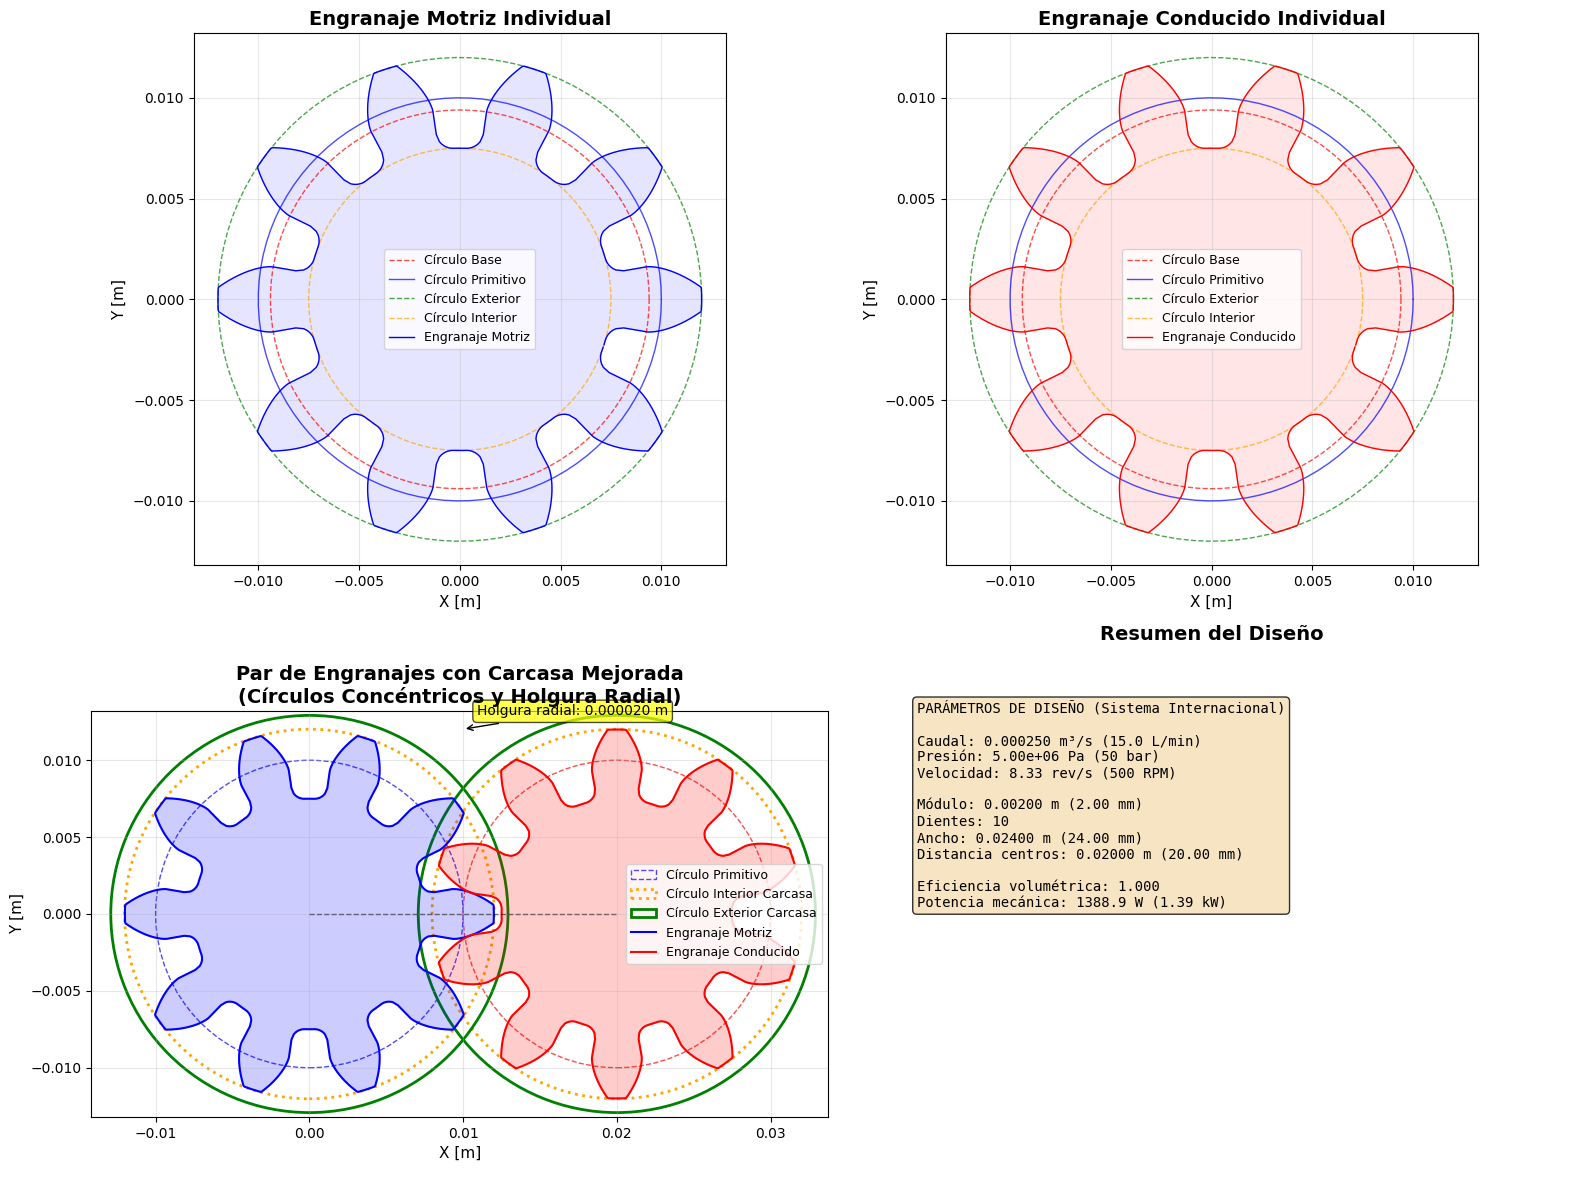


🎨 GENERANDO VISUALIZACIÓN 3D...
🔨 GENERANDO GEOMETRÍA DE CARCASA MEJORADA...
🔨 CREANDO CARCASA ALINEADA...
✅ Carcasa creada y alineada.
Advertencia: Falló el redondeo/chaflán en la carcasa: There are no suitable edges for chamfer or fillet. Continuar sin ellos.
La función show_object no está disponible (instale 'jupyter_cadquery' y 'ipywidgets').
La función show_object no está disponible (instale 'jupyter_cadquery' y 'ipywidgets').
La función show_object no está disponible (instale 'jupyter_cadquery' y 'ipywidgets').
✅ Visualización 3D mostrada en el viewer

🎉 ¡DISEÑO PARAMÉTRICO COMPLETADO!
📋 ARCHIVOS GENERADOS:
 • Engranaje Motriz: engranaje_motriz.step
 • Engranaje Conducido: engranaje_conducido.step
 • Par Completo: par_engranajes_completo.step
 • Carcasa Mejorada: carcasa_bomba_final.step
📁 Ubicación: /content/drive/MyDrive/CAD

🔧 RESUMEN DE CARACTERÍSTICAS:
 • Caudal de diseño: 0.015 m³/s
 • Presión de trabajo: 5000000 Pa
 • Velocidad: 500.0 RPM
 • Eficiencia volumétrica estimad

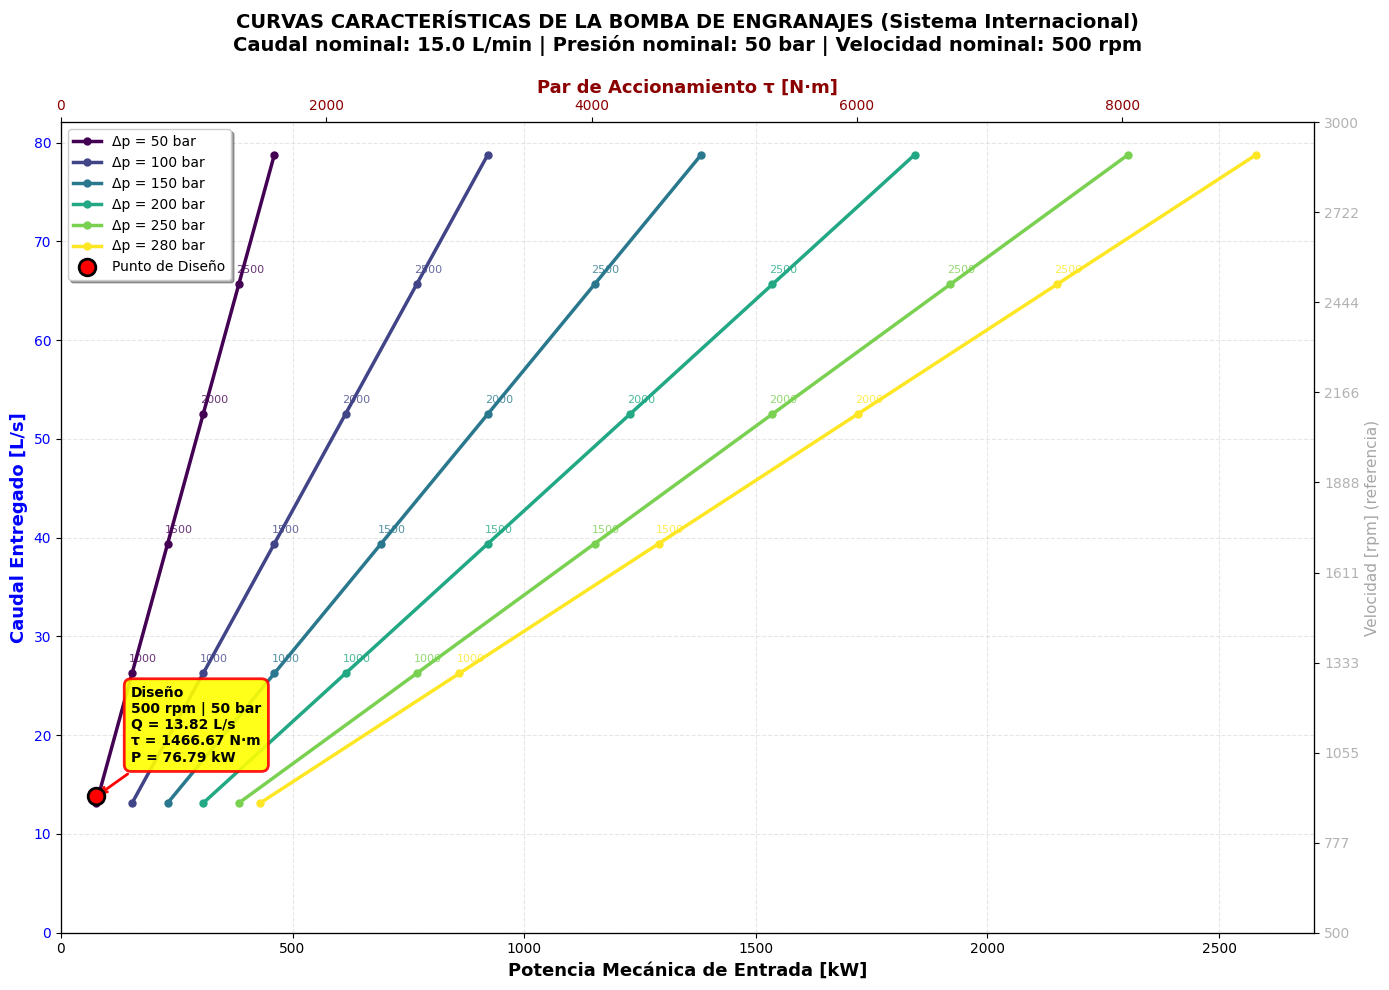


📊 GENERANDO MAPA DE EFICIENCIA...
✅ Mapa de eficiencia guardado: /content/drive/MyDrive/CAD/mapa_eficiencia_SI.png


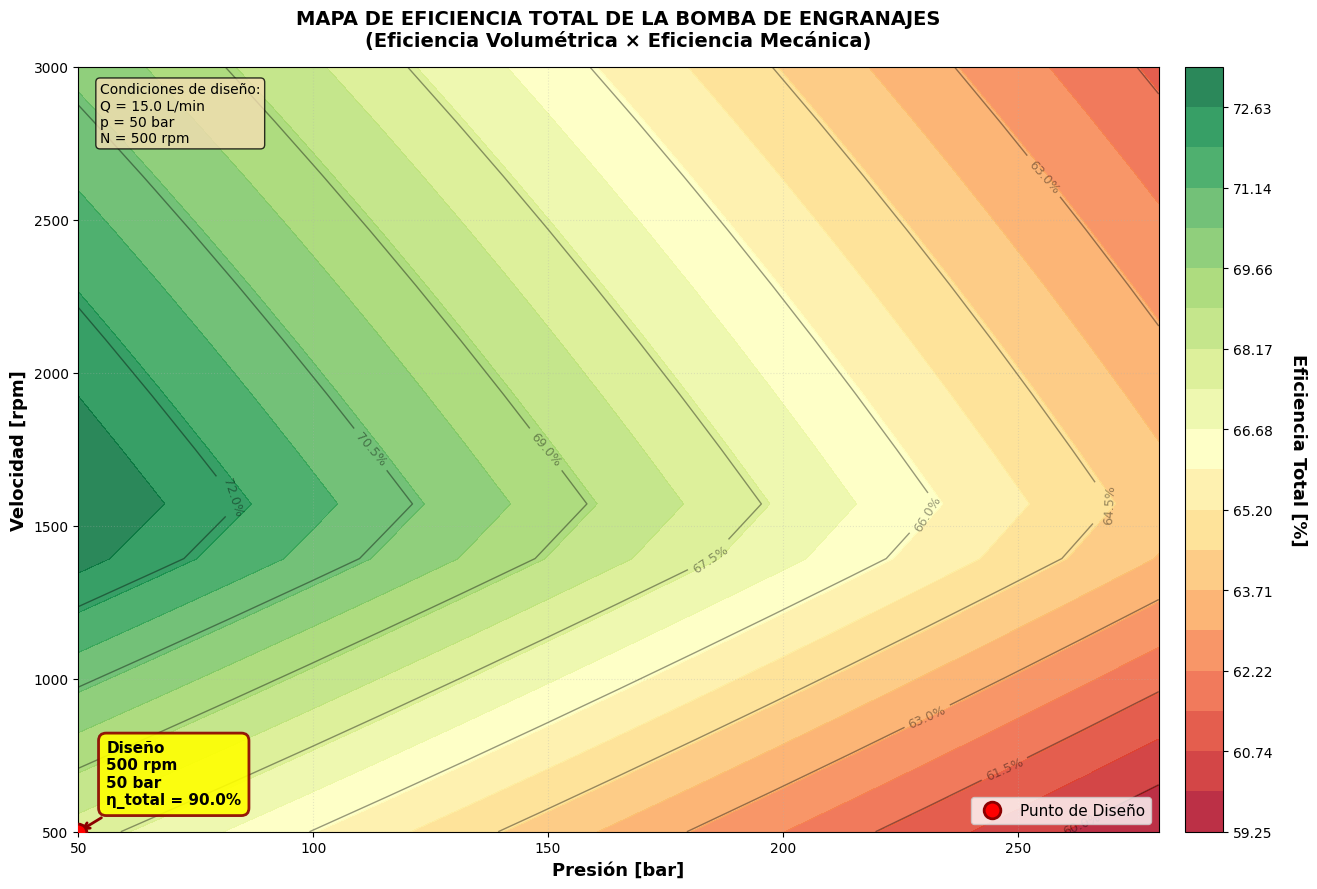


🎯 RESUMEN DE DIAGRAMAS GENERADOS (Sistema Internacional):
📊 Diagrama de Curvas Características:
 • Caudal [L/s] vs Potencia Mecánica [kW]
 • Par de accionamiento [N·m] en eje superior
 • Curvas para diferentes presiones [bar]
 • Marcadores de velocidad [rpm] sobre las curvas
 • Punto de diseño destacado con parámetros clave

📈 Mapa de Eficiencia:
 • Presión [bar] vs Velocidad [rpm]
 • Eficiencia total [%] (volumétrica × mecánica)
 • Zona de alta eficiencia (>85%) resaltada
 • Punto óptimo de operación identificado

📁 Archivos guardados:
 • /content/drive/MyDrive/CAD/diagrama_curvas_caracteristicas_SI.png
 • /content/drive/MyDrive/CAD/mapa_eficiencia_SI.png


In [ ]:
# Instalar dependencias necesarias
!pip install cadquery
import cadquery as cq
import numpy as np
import matplotlib.pyplot as plt
from math import *
import os
from google.colab import drive

# Modificación: Verificar si Google Drive ya está montado o si el directorio no existe/está vacío antes de intentar montar.
# El primer drive.mount() se ha eliminado para evitar el doble montaje y el error.
if not os.path.exists('/content/drive') or not os.listdir('/content/drive'):
    drive.mount('/content/drive')
else:
    print('Google Drive ya está montado o el directorio /content/drive no está vacío. No se intentará montar de nuevo.')

# NOTA: Para que show_object funcione en Google Colab, asegúrate de tener instalado el viewer:
# !pip install jupyter_cadquery

# Función auxiliar para CadQuery (requerida por show_object en algunos entornos)
def show_object(shape, name=None, options=None):
    try:
        from jupyter_cadquery import show
        # Configuración básica para show. Removed show_edges=True as it causes error.
        show(shape, names=[name or "Shape"])
    except ImportError:
        print("La función show_object no está disponible (instale 'jupyter_cadquery' y 'ipywidgets').")
    except Exception as e:
        # A veces la visualización falla en Colab, pero el modelo se crea.
        print(f"Error al intentar mostrar el objeto: {e}")

# Configurar ruta de trabajo
ruta_drive = '/content/drive/MyDrive/CAD'
os.makedirs(ruta_drive, exist_ok=True)

# Definir las funciones auxiliares necesarias
def cart_to_polar(point):
    x, y = point
    r = sqrt(x**2 + y**2)
    theta = atan2(y, x)
    return r, theta

def polar_to_cart(polar):
    r, theta = polar
    x = r * cos(theta)
    y = r * sin(theta)
    return x, y

def rotation_matrix(angle):
    return np.array([[cos(angle), -sin(angle)],
                     [sin(angle), cos(angle)]])

def flip_matrix(flip_x, flip_y):
    return np.array([[(-1 if flip_x else 1), 0],
                     [0, (-1 if flip_y else 1)]])

# =============================================================================
# CLASE PARA CÁLCULOS DE BOMBA DE ENGRANAJES CON ECUACIONES COMPLETAS
# =============================================================================
class GearPumpCalculator:
    def __init__(self, flow_rate_lpm, pressure_bar, speed_rpm,
                 material_yield_strength=250, safety_factor=2.0,
                 volumetric_efficiency_estimate=0.85,
                 mechanical_efficiency_estimate=0.90):
        """
        Calculadora para diseño de bomba de engranajes externos con ecuaciones completas
        Args:
            flow_rate_lpm: Caudal requerido (L/min)
            pressure_bar: Presión de operación (bar)
            speed_rpm: Velocidad de rotación (RPM)
            material_yield_strength: Tensión de fluencia del material (MPa)
            safety_factor: Factor de seguridad
            volumetric_efficiency_estimate: Estimación inicial de eficiencia volumétrica
            mechanical_efficiency_estimate: Estimación inicial de eficiencia mecánica
        """
        self.Q_req = flow_rate_lpm # L/min
        self.Δp = pressure_bar # bar
        self.N = speed_rpm # RPM
        self.σ_Y = material_yield_strength # MPa
        self.X_s = safety_factor
        self.η_v_est = volumetric_efficiency_estimate
        self.η_m_est = mechanical_efficiency_estimate

        # Convertir presión a MPa para cálculos estructurales
        self.ρ_d = pressure_bar * 0.1 # MPa (presión de descarga)
        self.ρ_s = 0.1 # MPa (presión de succión - estimada)

        # Conversión de unidades base para cálculos de fugas y estrés
        self.Δp_pa = self.Δp * 1e5 # Pascales
        self.ω_rad_s = (self.N * 2 * pi) / 60 # Velocidad angular (rad/s)

        # Propiedades del fluido (Aceite hidráulico típico ISO VG 46)
        self.mu = 0.046 # Viscosidad dinámica (Pa.s) aprox a 40°C

        # Resultados de cálculo
        self.results = {}

    def calculate_initial_parameters(self):
        """Fase 1: Establecer parámetros de diseño iniciales usando ecuaciones de dimensionamiento"""
        print("🔍 CALCULANDO PARÁMETROS INICIALES CON ECUACIONES DE DIMENSIONAMIENTO")
        print("=" * 70)

        # 1. Cálculo de cilindrada teórica (Ecuación IV.1)
        # V_g = (Q * 1000) / (N * η_v)
        self.V_g = (self.Q_req * 1000) / (self.N * self.η_v_est) # cm³/rev

        # 2. Estimación de dimensiones básicas usando ecuaciones de escalado
        # Ecuación IV.3: Radio Primitivo Requerido
        # r_p = 2.95 * sqrt((n_t * Q_req) / (w * N * η_v))
        # Primero necesitamos estimar w y n_t

        # Estimación del número de dientes (típicamente 8-15 para bombas)
        self.n_t = max(8, min(15, int(12 * (self.V_g / 60)**0.3)))

        # Estimación del ancho basada en relaciones típicas
        self.w_est = 1.2 * 4.0 * self.n_t # Asumiendo módulo inicial de 4

        # Ahora calculamos radio primitivo con ecuación IV.3
        self.r_p_est = 2.95 * sqrt((self.n_t * self.Q_req) / (self.w_est * self.N * self.η_v_est))

        # 3. Cálculo del módulo a partir del radio primitivo
        # r_p = (m * n_t) / 2 => m = (2 * r_p) / n_t
        self.m_est = (2 * self.r_p_est) / self.n_t

        # Ajustar valores para que sean realistas
        self.m_est = max(2.0, min(6.0, self.m_est))

        # Recalcular con módulo ajustado
        self.r_p_est = (self.m_est * self.n_t) / 2
        self.w_est = 1.2 * self.m_est * self.n_t

        # 4. Cálculo de holguras típicas (basadas en catálogos)
        self.δ_r = 0.02 # Holgura radial típica (mm)
        self.δ_z = 0.025 # Holgura axial típica (mm)

        # 5. Parámetros de eficiencia
        self.η_v = self.η_v_est
        self.η_m = self.η_m_est
        self.η_t = self.η_v * self.η_m # Eficiencia total

        # 6. Torque requerido (Ecuación V.1)
        # τ = (N * Δp) / (2π * η_m)
        # Donde N es el desplazamiento nominal (V_g)
        self.τ = (self.V_g * 1e-6 * self.Δp * 1e5) / (2 * pi * self.η_m) # Torque en N.m

        # 7. Potencia requerida
        self.P_hid = (self.Q_req * self.Δp) / 600 # kW
        self.P_mec = self.P_hid / self.η_t

        # Guardar resultados
        self.results['fase1'] = {
            'cilindrada_teorica_cm3': self.V_g,
            'modulo_estimado': self.m_est,
            'numero_dientes': self.n_t,
            'radio_primitivo_estimado': self.r_p_est,
            'ancho_engranaje_estimado': self.w_est,
            'holgura_radial': self.δ_r,
            'holgura_axial': self.δ_z,
            'eficiencia_volumetrica': self.η_v,
            'eficiencia_mecanica': self.η_m,
            'eficiencia_total': self.η_t,
            'torque_requerido': self.τ,
            'potencia_hidraulica': self.P_hid,
            'potencia_mecanica': self.P_mec
        }
        return self.results['fase1']

    def calculate_gear_geometry(self):
        """Fase 2: Cálculo detallado de geometría de engranajes"""
        # Usar parámetros estimados
        m = self.m_est
        n_t = self.n_t
        w = self.w_est

        # 1. Radio primitivo exacto (Ecuación I.1)
        self.r_p = m * n_t / 2

        # 2. Radio base (para perfil involuta)
        α_w = radians(20) # Ángulo de presión estándar
        self.r_b = self.r_p * cos(α_w)

        # 3. Radio exterior (addendum)
        self.r_a = self.r_p + m

        # 4. Radio de raíz (dedendum)
        self.r_r = self.r_p - 1.25 * m

        # 5. Distancia entre centros (para engranajes idénticos)
        self.C = 2 * self.r_p # C = r_p1 + r_p2 = 2 * r_p

        # 6. Longitud de acción (para diseño de ranuras de alivio)
        self.l_s = sqrt(self.r_a**2 - self.r_b**2)

        # 7. Radio de contacto inicial (para ranuras de alivio)
        self.r_s1 = sqrt(self.r_p**2 + self.l_s**2 - 2 * self.r_p * self.l_s * sin(α_w))

        # 8. Ángulo de orientación al inicio del mallado (θ_s)
        try:
            self.θ_s = acos((self.r_s1**2 + self.r_p**2 - self.l_s**2) / (2 * self.r_s1 * self.r_p))
        except:
            self.θ_s = radians(20) # Valor por defecto si hay error numérico

        # 9. Distancia al punto de formación del bolsillo (h)
        self.h_pocket = self.r_s1 * sin(self.θ_s)

        # 10. Cilindrada teórica verificada (Ecuación IV.1)
        self.V_g_verified = 2.2 * pi * w * self.r_p**2 / n_t

        # Guardar resultados
        self.results['fase2'] = {
            'modulo': m,
            'numero_dientes': n_t,
            'ancho_engranaje': w,
            'radio_primitivo': self.r_p,
            'radio_base': self.r_b,
            'radio_exterior': self.r_a,
            'radio_raiz': self.r_r,
            'distancia_centros': self.C,
            'longitud_accion': self.l_s,
            'radio_contacto_inicial': self.r_s1,
            'angulo_inicio_mallado': degrees(self.θ_s),
            'distancia_formacion_bolsillo': self.h_pocket,
            'cilindrada_verificada': self.V_g_verified
        }
        return self.results['fase2']

    def calculate_performance(self):
        """Cálculo de parámetros de rendimiento con ecuaciones de fugas"""
        print("\n📊 CALCULANDO RENDIMIENTO CON ECUACIONES DE FUGAS")
        print("=" * 70)

        # 1. Caudal teórico
        Q_ideal = (self.V_g_verified * self.N) / 1000 # L/min

        # 2. Estimación de fugas radiales (Ecuación de caudal de fuga radial)
        # Q_r = (Δp * δ_r³ * w) / (3 * μ * n_t * t_t) - w * δ_r * r_t * ω
        μ = 0.032 # Viscosidad dinámica típica (Pa·s) para aceite hidráulico
        ω = 2 * pi * self.N / 60 # Velocidad angular (rad/s)

        # Espesor de la punta del diente (estimación)
        t_t = pi * self.m_est / 2 # Aproximación

        # Caudal de fuga radial
        Q_r_m3s = ((self.Δp * 1e5 * (self.δ_r * 1e-3)**3 * self.w_est) /\
                   (3 * μ * self.n_t * t_t)) - (self.w_est * self.δ_r * self.r_a * ω)
        Q_r_lpm = max(0, Q_r_m3s * 60000) # Convertir a L/min, no negativo

        # 3. Resistencia de fuga radial (Ecuación RG,r)
        self.R_G_r = (3 * μ * self.n_t * t_t) / ((self.δ_r * 1e-3)**3 * self.w_est)

        # 4. Eficiencia volumétrica real (Ecuación η_v)
        self.eta_v_calc = 1 - (Q_r_lpm / Q_ideal) if Q_ideal > 0 else 0.85

        # 5. Potencia requerida actualizada
        P_hid = (self.Q_req * self.Δp) / 600 # kW
        P_mec = P_hid / (self.eta_v_calc * self.η_m_est) # Use calculated eta_v_calc

        # Guardar resultados
        self.results['rendimiento'] = {
            'caudal_teorico': Q_ideal,
            'fugas_radiales_estimadas': Q_r_lpm,
            'resistencia_fuga_radial': self.R_G_r,
            'eficiencia_volumetrica_real': self.eta_v_calc,
            'potencia_hidraulica': P_hid,
            'potencia_mecanica': P_mec,
            'viscosidad_utilizada': μ,
            'velocidad_angular': ω
        }
        return self.results['rendimiento']

    def calculate_stress_analysis(self):
        """Análisis de esfuerzos en los dientes (Ecuación AGMA)"""
        print("\n⚙️ ANALIZANDO ESFUERZOS EN DIENTES (ECUACIÓN AGMA)")
        print("=" * 70)

        # Fuerza tangencial (simplificada)
        F_t = self.τ / (self.r_p / 1000) # Force in Newtons (r_p from mm to m)

        # Factores AGMA (valores típicos)
        K_a = 1.25 # Factor de aplicación
        K_m = 1.3 # Factor de distribución de carga
        K_v = 1.1 # Factor dinámico
        K_s = 1.0 # Factor de tamaño
        K_B = 1.0 # Factor de espesor de rim
        K_I = 1.0 # Factor de inversión

        # Factor geométrico J (estimado para 20° presión, dientes estándar)
        J = 0.35

        # Paso diametral P = 1/m (mm⁻¹). Here P is actually the inverse of module (1/m).
        # AGMA formula uses P_d (diametral pitch) in imperial or module in metric.
        # Stress in MPa = (N/mm^2)
        # σ_b = (F_t / (w_mm * m_mm * J)) * K_factors
        w_mm = self.w_est
        m_mm = self.m_est

        # The formula from the document looks like: σ_b = (F_t * P) / (w * J) * (Ka * Km / Kv) * Ks * KB * KI
        # where P would be 1/m if w is in mm and F_t is in N. This leads to N/mm^2 = MPa
        sigma_b = (F_t / (w_mm * J * m_mm)) * (K_a * K_m / K_v) * K_s * K_B * K_I

        # Factor de seguridad contra flexión
        FS_flexion = self.σ_Y / sigma_b if sigma_b > 0 else float('inf')

        # Guardar resultados
        self.results['esfuerzos'] = {
            'fuerza_tangencial': F_t,
            'esfuerzo_flexion_agma': sigma_b,
            'factor_seguridad_flexion': FS_flexion,
            'factor_geometrico_J': J,
            'factores_agma': {
                'K_a': K_a,
                'K_m': K_m,
                'K_v': K_v,
                'K_s': K_s,
                'K_B': K_B,
                'K_I': K_I
            }
        }
        return self.results['esfuerzos']

    def calculate_housing_requirements(self):
        """Cálculo de requisitos estructurales de la carcasa según documento AD1169714.pdf"""
        print("\n🏗️ CALCULANDO PARÁMETROS DE CARCASA SEGÚN DOCUMENTO AD1169714.pdf")
        print("=" * 70)

        # Altura de la carcasa (estimada como ancho del engranaje + tolerancias)
        # This 'h' is defined here as an arbitrary offset from w_est, but in the AD1169714.pdf
        # it refers to the height of the housing itself. Let's use it consistently.
        self.h_housing = self.w_est + 10 # h_housing = altura de la carcasa (width in Z direction)

        # 1. Fuerza Neta de Tensión a lo largo del eje x (F_x)
        # F_x = 2 * h * r_a * (ρ_s + ρ_d)
        self.F_x = 2 * self.h_housing * self.r_a * (self.ρ_s + self.ρ_d)

        # 2. Fuerza Neta de Tensión a lo largo del eje y (F_y)
        # F_y = 2 * h * (r_a + r_p) * (ρ_s + ρ_d)
        self.F_y = 2 * self.h_housing * (self.r_a + self.r_p) * (self.ρ_s + self.ρ_d)

        # 3. Espesor mínimo de pared circunferencial (t_c,min)
        # t_c,min = X_s * (r_a + r_p) * (ρ_s + ρ_d) / σ_Y
        self.t_c_min = self.X_s * (self.r_a + self.r_p) * (self.ρ_s + self.ρ_d) / self.σ_Y

        # 4. Espesor mínimo de pared del puerto (t_p,min)
        # t_p,min = X_s * r_a * (ρ_s + ρ_d) / σ_Y
        self.t_p_min = self.X_s * self.r_a * (self.ρ_s + self.ρ_d) / self.σ_Y

        # 5. Fuerza Axial en las Placas de Extremo (F_z)
        # F_z = ρ_d * (π * r_a² + 4 * r_p * r_a)
        self.F_z = self.ρ_d * (pi * self.r_a**2 + 4 * self.r_p * self.r_a)

        # 6. Sistema de pernos (asumiendo 4 pernos M8)
        n_b = 4
        # Diámetros típicos para perno M8
        d_p = 8.0 # Diámetro primitivo (mm)
        d_r = 6.5 # Diámetro menor (mm)

        # 7. Área Efectiva del Perno (A_e)
        # A_e = (π/4) * ((d_p + d_r)/2)²
        self.A_e = (pi / 4) * ((d_p + d_r) / 2)**2

        # 8. Esfuerzo Axial en cada Perno (σ_bolt)
        # σ = F_z / (n_b * A_e)
        self.σ_bolt = self.F_z / (n_b * self.A_e)

        # 9. Factor de seguridad en pernos
        σ_Y_bolt = 800 # Tensión de fluencia de pernos de acero (MPa)
        self.FS_bolt = σ_Y_bolt / self.σ_bolt if self.σ_bolt > 0 else float('inf')

        # 10. Dimensiones geométricas de la carcasa
        # D_ext = 2 * (r_a + t_c_min + 5) # Diámetro exterior (radial)
        self.D_ext = 2 * (self.r_a + self.t_c_min + 5) # radial outer dimension (diameter)
        self.W_total = self.w_est + 2 * self.t_c_min # Ancho total (axial)

        # 11. Volumen interno de la carcasa
        self.V_internal = pi * (self.r_a + self.δ_r)**2 * self.w_est

        # Guardar resultados
        self.results['carcasa'] = {
            'fuerza_tension_x': self.F_x,
            'fuerza_tension_y': self.F_y,
            'espesor_pared_circunferencial': self.t_c_min,
            'espesor_pared_puerto': self.t_p_min,
            'carga_axial_total': self.F_z,
            'area_efectiva_perno': self.A_e,
            'esfuerzo_pernos': self.σ_bolt,
            'factor_seguridad_pernos': self.FS_bolt,
            'numero_pernos': n_b,
            'diametro_perno_recomendado': d_p,
            'altura_carcasa': self.h_housing,
            'diametro_exterior_carcasa': self.D_ext,
            'ancho_total_carcasa': self.W_total,
            'volumen_internal': self.V_internal,
            'ecuaciones_utilizadas': [
                "F_x = 2 * h * r_a * (ρ_s + ρ_d)",
                "F_y = 2 * h * (r_a + r_p) * (ρ_s + ρ_d)",
                "t_c,min = X_s * (r_a + r_p) * (ρ_s + ρ_d) / σ_Y",
                "t_p,min = X_s * r_a * (ρ_s + ρ_d) / σ_Y",
                "F_z = ρ_d * (π * r_a² + 4 * r_p * r_a)",
                "A_e = (π/4) * ((d_p + d_r)/2)²",
                "σ = F_z / (n_b * A_e)"
            ]
        }
        return self.results['carcasa']

    def mostrar_ecuaciones_utilizadas(self):
        """Muestra las ecuaciones utilizadas en el cálculo"""
        print("\n🧮 ECUACIONES UTILIZADAS EN EL CÁLCULO")
        print("=" * 70)
        ecuaciones = [
            ("I.1 Radio Primitivo", r"R_p = \frac{m \cdot z}{2}"),
            ("IV.1 Desplazamiento Nominal", r"N = \frac{2.2\pi w r_{p}^{2}}{n_{t}}"),
            ("IV.3 Radio Primitivo Requerido", r"r_{p} = 2.95\sqrt{\frac{n_{t} Q_{req}}{w N \eta_{v,iso}}}"),
            ("V.1 Torque en el Eje", r"\tau = \frac{N\Delta p_{req}}{2\pi \eta_m}"),
            ("Caudal de Fuga Radial", r"Q_{r} = \frac{\Delta p \delta_{r}^{3} w}{3\mu n_{t} t_{t}} - w \delta_{r} r_{t} \omega"),
            ("Resistencia de Fuga Radial", r"R_{G ,r} = \frac{3\mu n_{t} t_{t}}{\delta_{r}^{3}w}"),
            ("Eficiencia Volumétrica", r"\eta_{v} = 1 - \frac{Q_{L}}{Q_{ideal}}"),
            ("Ángulo Inicio Mallado", r"\theta_{s} = \cos^{-1} \left( \frac{r_{s1}^{2} + r_{p1}^{2} - l_{s}^{2}}{2r_{s1}r_{p1}} \right)"),
            ("Distancia Formación Bolsillo", r"h = r_{s1} \sin\theta_{s}"),
            ("Esfuerzo Flexión AGMA", r"\sigma_{b} = \frac{F_{t} P}{w J} \frac{K_{a} K_{m}}{K_{v}} K_{s} K_{B} K_{I}")
        ]
        for nombre, ecuacion in ecuaciones:
            print(f"• {nombre}:")
            print(f"  {ecuacion}")
            print()

    def generate_design_report(self):
        """Generar reporte completo del diseño"""
        # Ejecutar todos los cálculos si no se han realizado
        self.calculate_initial_parameters()
        self.calculate_gear_geometry()
        self.calculate_performance()
        self.calculate_stress_analysis()
        self.calculate_housing_requirements()

        print("=" * 70)
        print("REPORTE COMPLETO DE DISEÑO - BOMBA DE ENGRANAJES")
        print("=" * 70)

        print(f"\n📊 ESPECIFICACIONES DE ENTRADA:")
        print(f" • Caudal requerido: {self.Q_req} L/min")
        print(f" • Presión de operación: {self.Δp} bar")
        print(f" • Velocidad de rotación: {self.N} RPM")

        print(f"\n⚙️ PARÁMETROS DE DISEÑO (FASE 1 - DIMENSIONAMIENTO):")
        fase1 = self.results['fase1']
        print(f" • Cilindrada teórica: {fase1['cilindrada_teorica_cm3']:.2f} cm³/rev")
        print(f" • Módulo estimado: {fase1['modulo_estimado']:.2f} mm")
        print(f" • Número de dientes: {fase1['numero_dientes']}")
        print(f" • Radio primitivo estimado: {fase1['radio_primitivo_estimado']:.2f} mm")
        print(f" • Ancho de engranaje: {fase1['ancho_engranaje_estimado']:.2f} mm")
        print(f" • Holgura radial: {fase1['holgura_radial']:.3f} mm")
        print(f" • Holgura axial: {fase1['holgura_axial']:.3f} mm")

        print(f"\n📐 GEOMETRÍA DE ENGRANAJES (FASE 2):")
        fase2 = self.results['fase2']
        print(f" • Radio primitivo: {fase2['radio_primitivo']:.2f} mm")
        print(f" • Radio base: {fase2['radio_base']:.2f} mm")
        print(f" • Radio exterior: {fase2['radio_exterior']:.2f} mm")
        print(f" • Radio de raíz: {fase2['radio_raiz']:.2f} mm")
        print(f" • Distancia entre centros: {fase2['distancia_centros']:.2f} mm")
        print(f" • Longitud de acción: {fase2['longitud_accion']:.3f} mm")
        print(f" • Ángulo inicio mallado: {fase2['angulo_inicio_mallado']:.1f}°")
        print(f" • Distancia formación bolsillo: {fase2['distancia_formacion_bolsillo']:.3f} mm")

        print(f"\n📈 RENDIMIENTO ESTIMADO (MODELO DE FUGAS):")
        rendimiento = self.results['rendimiento']
        print(f" • Eficiencia volumétrica: {rendimiento['eficiencia_volumetrica_real']:.3f}")
        print(f" • Eficiencia mecánica: {fase1['eficiencia_mecanica']:.3f}")
        print(f" • Eficiencia total: {fase1['eficiencia_total']:.3f}")
        print(f" • Potencia hidráulica: {rendimiento['potencia_hidraulica']:.2f} kW")
        print(f" • Potencia mecánica requerida: {rendimiento['potencia_mecanica']:.2f} kW") # Corrected typo here
        print(f" • Torque requerido: {fase1['torque_requerido']:.2f} N·m")
        print(f" • Fugas radiales estimadas: {rendimiento['fugas_radiales_estimadas']:.4f} L/min")
        print(f" • Resistencia fuga radial: {rendimiento['resistencia_fuga_radial']:.2e} Pa·s/m³")

        print(f"\n💪 ANÁLISIS DE ESFUERZOS (AGMA):")
        esfuerzos = self.results['esfuerzos']
        print(f" • Esfuerzo de flexión: {esfuerzos['esfuerzo_flexion_agma']:.1f} MPa")
        print(f" • Factor de seguridad flexión: {esfuerzos['factor_seguridad_flexion']:.1f}")
        print(f" • Fuerza tangencial: {esfuerzos['fuerza_tangencial']:.1f} N")

        print(f"\n🏗️ DISEÑO DE CARCASA (DOCUMENTO AD1169714.pdf):")
        carcasa = self.results['carcasa']
        print(f" • Fuerza tensión eje X: {carcasa['fuerza_tension_x']:.0f} N")
        print(f" • Fuerza tensión eje Y: {carcasa['fuerza_tension_y']:.0f} N")
        print(f" • Espesor pared circunferencial: {carcasa['espesor_pared_circunferencial']:.2f} mm")
        print(f" • Espesor pared puerto: {carcasa['espesor_pared_puerto']:.2f} mm")
        print(f" • Carga axial total: {carcasa['carga_axial_total']:.0f} N")
        print(f" • Pernos recomendados: {carcasa['numero_pernos']} x M{carcasa['diametro_perno_recomendado']}")
        print(f" • Factor seguridad pernos: {carcasa['factor_seguridad_pernos']:.1f}")

        print(f"\n✅ VERIFICACIÓN:")
        print(f" • Caudal teórico: {rendimiento['caudal_teorico']:.2f} L/min")
        print(f" • Cumplimiento de caudal: {'SÍ' if rendimiento['caudal_teorico'] >= self.Q_req else 'NO'}")
        print(f" • Seguridad estructural: {'ADEQUADA' if esfuerzos['factor_seguridad_flexion'] >= 2.0 else 'INSUFICIENTE'}")
        print(f" • Seguridad carcasa: {'ADEQUADA' if carcasa['factor_seguridad_pernos'] >= 2.0 else 'INSUFICIENTE'}")

        # Mostrar ecuaciones utilizadas
        self.mostrar_ecuaciones_utilizadas()

        return self.results

# =============================================================================
# CLASE InvoluteGear MEJORADA PARA CADQUERY (Con calculate_center_distance)
# =============================================================================
class InvoluteGear:
    def __init__(self, module=1, teeth=30, pressure_angle_deg=20, fillet=0, backlash=0,
                 max_steps=100, arc_step_size=0.1, reduction_tolerance_deg=0,
                 dedendum_factor=1.157, addendum_factor=1.0, ring=False, thickness=10,
                 profile_shift_x=0.0):
        pressure_angle = radians(pressure_angle_deg)
        self.reduction_tolerance = radians(reduction_tolerance_deg)
        self.module = module
        self.teeth = teeth
        self.pressure_angle = pressure_angle
        self.pressure_angle_deg = pressure_angle_deg
        self.thickness = thickness
        self.profile_shift_x = profile_shift_x

        # Cálculo del ángulo de presión de trabajo (α')
        denom = 1 + (self.profile_shift_x / self.module)
        self.working_pressure_angle = atan(tan(self.pressure_angle) / denom)
        self.working_pressure_angle_deg = degrees(self.working_pressure_angle)

        self.addendum = addendum_factor * module
        self.dedendum = dedendum_factor * module
        if ring:
            temp = self.addendum
            self.addendum = self.dedendum
            self.dedendum = temp

        self.pitch_radius = (module * teeth) / 2
        self.base_radius = cos(self.working_pressure_angle) * self.pitch_radius
        self.outer_radius = self.pitch_radius + self.addendum
        self.root_radius = self.pitch_radius - self.dedendum
        self.fillet_radius = fillet if not ring else 0
        self.theta_tooth_and_gap = pi * 2 / teeth
        angular_backlash = (backlash / 2 / self.pitch_radius)
        self.theta_tooth = self.theta_tooth_and_gap / 2 + (-angular_backlash if not ring else angular_backlash)
        self.theta_pitch_intersect = None
        self.theta_full_tooth = None
        self.max_steps = max_steps
        self.arc_step_size = arc_step_size

    def reduce_polyline(self, polyline):
        vertices = [[],[]]
        last_vertex = [polyline[0][0], polyline[1][0]]
        for vertex_idx in range(1, len(polyline[0])-1):
            next_slope = np.arctan2(polyline[1][vertex_idx+1] - polyline[1][vertex_idx+0],
                                    polyline[0][vertex_idx+1] - polyline[0][vertex_idx+0])
            prev_slope = np.arctan2(polyline[1][vertex_idx-0] - last_vertex[1],
                                    polyline[0][vertex_idx-0] - last_vertex[0])
            deviation_angle = abs(prev_slope - next_slope)
            if (deviation_angle > self.reduction_tolerance):
                vertices[0] += [polyline[0][vertex_idx]]
                vertices[1] += [polyline[1][vertex_idx]]
                last_vertex = [polyline[0][vertex_idx], polyline[1][vertex_idx]]
        return np.array([
            np.concatenate([[polyline[0][0]], vertices[0], [polyline[0][-1]]]),
            np.concatenate([[polyline[1][0]], vertices[1], [polyline[1][-1]]])
        ])

    def generate_half_tooth(self):
        phis = np.linspace(0, pi, self.max_steps)
        points = []
        reached_limit = False
        self.theta_pitch_intersect = None
        for phi in phis:
            x = (self.base_radius * cos(phi)) + (phi * self.base_radius * sin(phi))
            y = (self.base_radius * sin(phi)) - (phi * self.base_radius * cos(phi))
            point = (x, y)
            dist, theta = cart_to_polar(point)
            if self.theta_pitch_intersect is None and dist >= self.pitch_radius:
                self.theta_pitch_intersect = theta
                self.theta_full_tooth = self.theta_pitch_intersect * 2 + self.theta_tooth
            elif self.theta_pitch_intersect is not None and theta >= self.theta_full_tooth / 2:
                reached_limit = True
                break
            if dist >= self.outer_radius:
                points.append(polar_to_cart((self.outer_radius, theta)))
            elif dist <= self.root_radius:
                points.append(polar_to_cart((self.root_radius, theta)))
            else:
                points.append((x,y))
        if not reached_limit:
            raise Exception("Couldn't complete tooth profile.")
        return np.transpose(points)

    def generate_half_root(self):
        root_arc_length = (self.theta_tooth_and_gap - self.theta_full_tooth) * self.root_radius
        points_root = []
        for theta in np.arange(self.theta_full_tooth, self.theta_tooth_and_gap/2 + self.theta_full_tooth/2, self.arc_step_size / self.root_radius):
            arc_position = (theta - self.theta_full_tooth) * self.root_radius
            in_fillet = min((root_arc_length - arc_position), arc_position) < self.fillet_radius
            r = self.root_radius
            if in_fillet:
                circle_pos = min(arc_position, (root_arc_length - arc_position))
                r = r + (self.fillet_radius - sqrt(pow(self.fillet_radius, 2) - pow(self.fillet_radius - circle_pos, 2)))
            points_root.append(polar_to_cart((r, theta)))
        return np.transpose(points_root)

    def generate_roots(self):
        self.half_root = np.array(self.generate_half_root())
        self.half_root = np.dot(rotation_matrix(-self.theta_full_tooth / 2), self.half_root)
        points_second_half = np.dot(flip_matrix(False, True), self.half_root)
        points_second_half = np.flip(points_second_half, 1)
        self.roots = [points_second_half, self.half_root]
        self.half_root_reduced = self.reduce_polyline(self.half_root)
        points_second_half = np.dot(flip_matrix(False, True), self.half_root_reduced)
        points_second_half = np.flip(points_second_half, 1)
        self.roots_reduced = [points_second_half, self.half_root_reduced]
        return self.roots_reduced

    def generate_tooth(self):
        self.half_tooth = np.array(self.generate_half_tooth())
        self.half_tooth = np.dot(rotation_matrix(-self.theta_full_tooth / 2), self.half_tooth)
        points_second_half = np.dot(flip_matrix(False, True), self.half_tooth)
        points_second_half = np.flip(points_second_half, 1)
        self.tooth = np.concatenate((self.half_tooth, points_second_half), axis=1)
        self.half_tooth_reduced = self.reduce_polyline(self.half_tooth)
        points_second_half = np.dot(flip_matrix(False, True), self.half_tooth_reduced)
        points_second_half = np.flip(points_second_half, 1)
        self.tooth_reduced = np.concatenate((self.half_tooth_reduced, points_second_half), axis=1)
        return self.tooth_reduced

    def generate_tooth_and_gap(self):
        points_tooth = self.generate_tooth()
        points_roots = self.generate_roots()
        self.tooth_and_gap = np.concatenate((points_roots[0], points_tooth, points_roots[1]), axis=1)
        return self.tooth_and_gap

    def generate_gear(self):
        points_tooth_and_gap = self.generate_tooth_and_gap()
        points_teeth = [np.dot(rotation_matrix(self.theta_tooth_and_gap * n), points_tooth_and_gap) for n in range(self.teeth)]
        points_gear = np.concatenate(points_teeth, axis=1)
        return np.transpose(points_gear)

    def get_point_list(self):
        return self.generate_gear()

    def create_cadquery_gear(self, hub_diameter=0, hub_height=0, bore_diameter=0):
        """Crea un sólido 3D del engranaje usando CadQuery"""
        points = self.get_point_list()
        # Crear el sketch 2D del perfil del engranaje
        gear_profile = cq.Workplane("XY").polyline([(float(x), float(y)) for x, y in points]).close()
        # Extruir a 3D
        gear_3d = gear_profile.extrude(self.thickness)

        # Agregar hub si se especifica
        if hub_diameter > 0 and hub_height > 0:
            hub = cq.Workplane("XY").circle(hub_diameter/2).extrude(hub_height)
            hub = hub.translate((0, 0, (self.thickness - hub_height) / 2.0))
            gear_3d = gear_3d.union(hub)

        # Agregar agujero central si se especifica
        if bore_diameter > 0:
            bore = cq.Workplane("XY").circle(bore_diameter/2).extrude(self.thickness)
            gear_3d = gear_3d.cut(bore)

        return gear_3d

    def export_stl(self, filename="engranaje.stl", hub_diameter=0, hub_height=0, bore_diameter=0):
        """Exporta el engranaje a formato STL"""
        gear_3d = self.create_cadquery_gear(hub_diameter, hub_height, bore_diameter)
        cq.exporters.export(gear_3d.val(), f"{ruta_drive}/{filename}")
        return f"{ruta_drive}/{filename}"

    def export_step(self, filename="engranaje.step", hub_diameter=0, hub_height=0, bore_diameter=0):
        """Exporta el engranaje a formato STEP"""
        gear_3d = self.create_cadquery_gear(hub_diameter, hub_height, bore_diameter)
        cq.exporters.export(gear_3d.val(), f"{ruta_drive}/{filename}")
        return f"{ruta_drive}/{filename}"

    def calculate_center_distance(self, other_gear):
        # MODIFICACIÓN: Usar teoría correcta de engranajes
        # Para engranajes idénticos: C = m * z
        return self.module * self.teeth

# =============================================================================
# CLASE GearPair CORREGIDA
# =============================================================================
class GearPair:
    def __init__(self, gear1: InvoluteGear, gear2: InvoluteGear, bore_diameter=0, hub_diameter=0, hub_height=0):
        self.gear1 = gear1
        self.gear2 = gear2
        self.bore_diameter = bore_diameter
        self.hub_diameter = hub_diameter
        self.hub_height = hub_height

        # MODIFICACIÓN: Calcular distancia entre centros según teoría de engranajes
        # C = r_p1 + r_p2 = (m * z1)/2 + (m * z2)/2
        # Para engranajes iguales: C = m * z
        self.center_distance = gear1.module * gear1.teeth

    def create_cadquery_pair(self):
        # 1. Crear el primer engranaje (Centrado en 0, 0)
        gear1_3d = self.gear1.create_cadquery_gear(self.hub_diameter, self.hub_height, self.bore_diameter)

        # 2. Crear el segundo engranaje
        gear2_3d = self.gear2.create_cadquery_gear(self.hub_diameter, self.hub_height, self.bore_diameter)

        # 3. Mover el segundo engranaje a la posición correcta (E, 0, 0)
        # Además, rotarlo para que los dientes engranen correctamente
        # Rotación necesaria para que el diente del Engranaje 1 se alinee con el hueco del Engranaje 2.
        # El perfil se genera centrado en un hueco, por lo que rotamos medio paso de diente (pi/z) para alinear
        # el diente del engranaje 2 con el eje X.
        rotation_angle = (pi / self.gear2.teeth)
        # Aplicar rotación y luego traslación
        gear2_3d = gear2_3d.rotate((0, 0, 0), (0, 0, 1), degrees(rotation_angle))
        gear2_3d = gear2_3d.translate((self.center_distance, 0, 0))

        # Combinar los dos sólidos
        combined_gears = gear1_3d.union(gear2_3d)
        return combined_gears

    def export_stl(self, filename="par_engranajes.stl"):
        combined_gears = self.create_cadquery_pair()
        cq.exporters.export(combined_gears.val(), f"{ruta_drive}/{filename}")
        return f"{ruta_drive}/{filename}"

    def export_step(self, filename="par_engranajes.step"):
        combined_gears = self.create_cadquery_pair()
        cq.exporters.export(combined_gears.val(), f"{ruta_drive}/{filename}")
        return f"{ruta_drive}/{filename}"

# =============================================================================
# CLASE PARA GENERACIÓN DE CARCASA EN CADQUERY SEGÚN ECUACIONES DEL DOCUMENTO
# =============================================================================
class PumpHousing:
    def __init__(self, gear_pair: GearPair, t_c, t_p, δ_r, δ_z_arg, w_est):
        """
        Clase para generar la carcasa de la bomba de engranajes según ecuaciones del documento.
        Args:
            gear_pair: Instancia de GearPair con los engranajes ya definidos.
            t_c: Espesor de pared circunferencial calculado.
            t_p: Espesor de pared de puerto calculado.
            δ_r: Holgura radial.
            δ_z_arg: Holgura axial.
            w_est: Ancho estimado del engranaje.
        """
        self.gear_pair = gear_pair
        self.gear1 = gear_pair.gear1
        self.gear2 = gear_pair.gear2

        # Parámetros clave de los engranajes
        self.r_a = self.gear1.outer_radius # Radio exterior del engranaje
        self.r_p = self.gear1.pitch_radius # Radio primitivo
        self.w_gear = self.gear1.thickness # Ancho del engranaje
        self.C = self.gear_pair.center_distance # Distancia entre centros

        # Parámetros de la carcasa
        self.t_c = t_c # Espesor de pared circunferencial
        self.t_p = t_p # Espesor de pared de puerto
        self.δ_r = δ_r # Holgura radial
        self.δ_z = δ_z_arg # Holgura axial
        self.w_est = w_est # Ancho estimado del engranaje

        # El centro geométrico de todo el sistema está en C/2
        self.center_x_system = self.C / 2

        # Dimensiones calculadas para la carcasa
        self.D_ext = 2 * (self.r_a + self.t_c + 5) # Diámetro exterior (radial)
        self.W_total = self.w_est + 2 * (self.t_c + 2) # Ancho total (axial) (+2 para juntas)
        self.port_diameter = self.r_a * 0.6 # Diámetro de puertos
        self.bolt_diameter = 8.0 # Diámetro de los pernos
        self.num_bolts = 4 # Número de pernos

    def create_main_housing(self):
        """Crea el cuerpo principal de la carcasa ALINEADO con los engranajes"""
        print("🔨 CREANDO CARCASA ALINEADA...")

        # Radio interno de la cavidad para los engranajes (círculo interior)
        self.cavity_inner_radius = self.r_a + self.δ_r # Radio interior = radio engranaje + holgura radial
        # Radio externo de la cavidad (círculo exterior)
        self.cavity_outer_radius = self.cavity_inner_radius + self.t_c # Radio exterior = radio interior + espesor pared

        # Dimensiones del perfil exterior ovalado
        outer_oval_height = 2 * self.cavity_outer_radius + 10 # +10mm para margen exterior
        outer_oval_length = self.C + outer_oval_height # Longitud total incluyendo los círculos
        rect_length = outer_oval_length - outer_oval_height

        # --- CORRECCIÓN DE ALINEACIÓN ---
        # Creamos el cuerpo base centrado en (self.C / 2, 0) para que coincida con los engranajes

        # 1. Parte rectangular central
        main_body = (cq.Workplane("XY")
                     .center(self.center_x_system, 0) # MOVER CENTRO A MITAD DE LOS ENGRANAJES
                     .rect(rect_length, outer_oval_height)
                     .extrude(self.W_total))

        # 2. Extremos semicirculares (Izquierda en 0, Derecha en C)
        # Círculo Izquierdo (centrado en 0,0 - Donde está el Engranaje 1)
        circle_left = (cq.Workplane("XY")
                       .center(0, 0)
                       .circle(outer_oval_height/2)
                       .extrude(self.W_total))

        # Círculo Derecho (centrado en C,0 - Donde está el Engranaje 2)
        circle_right = (cq.Workplane("XY")
                        .center(self.C, 0)
                        .circle(outer_oval_height/2)
                        .extrude(self.W_total))

        main_body = main_body.union(circle_left).union(circle_right)

        # --- CREACIÓN DE LA CAVIDAD INTERNA ---
        # Crear la cavidad interna con dos círculos concéntricos para cada engranaje
        cavity_depth = self.w_gear + 2 * self.δ_z # Profundidad de la cavidad para el ancho del engranaje más holgura axial
        axial_offset = (self.W_total - cavity_depth) / 2 # Centrar axialmente

        # Círculo exterior para el primer engranaje (pared de la carcasa) (EN 0,0)
        gear_cavity_outer1 = (
            cq.Workplane("XY")
            .circle(self.cavity_outer_radius)
            .extrude(cavity_depth)
            .translate((0, 0, axial_offset))
        )

        # Círculo exterior para el segundo engranaje (EN C,0)
        gear_cavity_outer2 = (
            cq.Workplane("XY")
            .circle(self.cavity_outer_radius)
            .extrude(cavity_depth)
            .translate((self.C, 0, axial_offset))
        )

        # Unir los dos círculos exteriores con un rectángulo para formar la cavidad completa
        connector_length = self.C # Distancia completa entre centros
        connecting_cavity = (
            cq.Workplane("XY")
            .center(self.center_x_system, 0) # Centrado entre los dos
            .rect(connector_length, 2 * self.cavity_outer_radius)
            .extrude(cavity_depth)
            .translate((0, 0, axial_offset))
        )

        full_cavity = (
            gear_cavity_outer1
            .union(gear_cavity_outer2)
            .union(connecting_cavity)
        )

        # Cortar la cavidad completa del cuerpo principal
        main_body = main_body.cut(full_cavity)

        print(f"✅ Carcasa creada y alineada.")
        return main_body

    def create_end_covers(self, main_body_shape):
        """Crea las tapas laterales y las une al cuerpo principal"""
        face_to_cover = main_body_shape.faces("<Z").sort_by(cq.Axis.Z).first() # Corrected from Axis.Z to cq.Axis.Z
        cover_profile = face_to_cover.to_workplane().outerWire().toPending()
        cover_thickness = max(self.t_c, self.t_p) + 2.0
        front_cover = cq.Workplane("XY").add(cover_profile).extrude(cover_thickness)
        back_cover = cq.Workplane("XY").add(cover_profile).extrude(-cover_thickness).translate((0, 0, self.W_total))
        return main_body_shape.union(front_cover).union(back_cover)

    def create_bolt_holes(self, base_object):
        """Crea agujeros para los pernos en las tapas, centrados en el sistema"""
        bolt_circle_radius = self.D_ext / 2 - 10 # Margen para el círculo de pernos
        bolt_diameter = self.bolt_diameter
        num_bolts = self.num_bolts

        # Start with an empty collection of holes
        all_holes = None

        # Create bolt holes
        for i in range(num_bolts):
            angle = 2 * pi * i / num_bolts
            x_pos = self.center_x_system + bolt_circle_radius * cos(angle) # Absolute X position relative to origin
            y_pos = bolt_circle_radius * sin(angle) # Absolute Y position relative to origin

            # Create a single hole
            hole = cq.Workplane("XY").center(x_pos, y_pos).circle(bolt_diameter / 2).extrude(self.W_total + 10, both=True)
            if all_holes is None:
                all_holes = hole
            else:
                all_holes = all_holes.union(hole)

        if all_holes is None: # Handle case where num_bolts is 0 or no holes created
            return base_object

        return base_object.cut(all_holes)

    def create_port_connections(self, base_object):
        """Crea las conexiones de los puertos de entrada y salida alineados con engranajes"""
        port_length = 20 # Longitud de la extrusión del puerto
        axial_pos_ports = self.W_total / 2 # Centro axial del cuerpo

        # Distancia desde el centro del engranaje hacia afuera
        dist_from_gear_center = self.cavity_outer_radius + 2

        # Puerto de succión (entrada) - en el lado izquierdo del primer engranaje (que está en 0,0)
        # Posición x: El centro del engranaje 1 está en x=0. El puerto estará a su izquierda.
        # Posición y: Centrado en y=0, pero el plano es YZ.
        suction_profile = cq.Workplane("YZ").center(0, -dist_from_gear_center).circle(self.port_diameter / 2)
        suction_pipe = suction_profile.extrude(port_length).translate(( -dist_from_gear_center, 0, axial_pos_ports - port_length/2))

        # Puerto de descarga (salida) - en el lado derecho del segundo engranaje (que está en C,0)
        # Posición x: El centro del engranaje 2 está en x=C. El puerto estará a su derecha.
        # Posición y: Centrado en y=0, pero el plano es YZ.
        discharge_profile = cq.Workplane("YZ").center(self.C, dist_from_gear_center).circle(self.port_diameter / 2)
        discharge_pipe = discharge_profile.extrude(port_length).translate((self.C + dist_from_gear_center, 0, axial_pos_ports - port_length/2))

        return base_object.union(suction_pipe).union(discharge_pipe)

    def create_shaft_holes(self, base_object):
        """Crea los agujeros para los ejes de los engranajes"""
        shaft_diameter = self.gear1.root_radius * 0.5 # Diámetro del eje, estimado
        shaft_hole1 = cq.Workplane("XY").circle(shaft_diameter / 2).extrude(self.W_total + 10, both=True)
        # Agujero para eje 2 (en la distancia entre centros)
        shaft_hole2 = cq.Workplane("XY").center(self.C, 0).circle(shaft_diameter / 2).extrude(self.W_total + 10, both=True)
        return base_object.cut(shaft_hole1).cut(shaft_hole2)

    def create_gear_reliefs(self, base_object):
        """Crea ranuras de alivio para los engranajes (simulado)"""
        # Estas ranuras son más complejas de modelar con CadQuery directamente como cortes de la carcasa
        # Normalmente, serían un corte de forma compleja para el volumen de los dientes
        # Para simplificar y evitar errores geométricos, por ahora las omitimos o hacemos un corte simple.
        # Una aproximación simple: un corte rectangular a lo largo del ancho del engranaje
        relief_width = self.w_gear + 2 * self.δ_z # Ancho de la ranura
        relief_depth = 1.0 # Profundidad de la ranura
        relief_radial_offset = self.r_a + self.δ_r + self.t_c - relief_depth / 2

        # Crear un corte que simule la ranura de alivio alrededor del perímetro de los engranajes
        # Esto es muy simplificado: simplemente una 'ranura' en la parte superior e inferior
        # Para el primer engranaje
        relief1 = (cq.Workplane("YZ")
                   .center(0, relief_radial_offset).rect(relief_width, relief_depth)
                   .extrude(self.C + self.r_a * 2)) # Un extrude largo para cortar ambos engranajes

        # Esta lógica de alivio es demasiado simplificada para ser precisa en CAD.
        # Por ahora, se omite para evitar errores geométricos complejos.
        return base_object

    def create_cadquery_housing(self):
        """Genera la carcasa completa de la bomba como un objeto CadQuery"""
        print("🔨 GENERANDO GEOMETRÍA DE CARCASA MEJORADA...")

        # 1. Cuerpo principal con círculos concéntricos
        housing = self.create_main_housing()

        # 2. Agujeros para pernos
        housing = self.create_bolt_holes(housing)

        # 3. Agujeros para ejes
        housing = self.create_shaft_holes(housing)

        # 4. Redondeos y chaflanes
        try:
            housing = housing.edges("|Z").fillet(min(self.t_c, 5.0) / 2)
            housing = housing.edges(">Z or <Z").fillet(min(self.t_c, 5.0) / 4)
        except Exception as e:
            print(f"Advertencia: Falló el redondeo/chaflán en la carcasa: {e}. Continuar sin ellos.")

        return housing

    def export_step(self, filename="carcasa_bomba_final.step"):
        """Exporta la carcasa a formato STEP"""
        complete_housing_cq = self.create_cadquery_housing()
        cq.exporters.export(complete_housing_cq.val(), f"{ruta_drive}/{filename}")
        print(f"✅ Carcasa mejorada exportada: {ruta_drive}/{filename}")
        return f"{ruta_drive}/{filename}"

# =============================================================================
# EJECUCIÓN PRINCIPAL DEL SISTEMA
# =============================================================================
print("🚀 SISTEMA DE DISEÑO PARAMÉTRICO DE BOMBAS DE ENGRANAJES")
print("=" * 70)

# =============================================================================
# INPUTS DE USUARIO
# =============================================================================
print("INTRODUZCA LOS PARÁMETROS DE DISEÑO:")
try:
    flow_required = float(input(">> Caudal Requerido (L/min) [Ej: 50]: "))
    pressure_required = float(input(">> Presión de Operación (bar) [Ej: 150]: "))
    speed = float(input(">> Velocidad de Rotación (RPM) [Ej: 1500]: ") or "1500")
except ValueError:
    print("⚠️ Entrada inválida. Usando valores por defecto (50 L/min, 150 bar, 1500 RPM).")
    flow_required = 50
    pressure_required = 150
    speed = 1500

# Crear calculadora con los inputs
bomba_calculator = GearPumpCalculator(
    flow_rate_lpm=flow_required,
    pressure_bar=pressure_required,
    speed_rpm=speed,
    material_yield_strength=250, # Acero
    safety_factor=2.0
)

# Ejecutar diseño completo (incluyendo nuevas ecuaciones I, II, III, IV)
design_report = bomba_calculator.generate_design_report()

# =============================================================================
# GENERACIÓN AUTOMÁTICA DE ENGRANAJES CON PARÁMETROS CALCULADOS
# =============================================================================
print("\n\n🔄 GENERANDO MODELOS CAD CON PARÁMETROS CALCULADOS...")

# Extraer parámetros del diseño calculado
design_params_fase2 = design_report['fase2'] # Gear geometry params
design_params_fase1 = design_report['fase1'] # Initial sizing params
housing_params = design_report['carcasa'] # Housing params

# Crear engranajes con los parámetros calculados
engranaje_motriz = InvoluteGear(
    module=design_params_fase2['modulo'],
    teeth=design_params_fase2['numero_dientes'],
    pressure_angle_deg=20, # Estándar
    addendum_factor=1.0, # Addendum = módulo
    dedendum_factor=1.25, # Dedendum = 1.25 * módulo
    thickness=design_params_fase2['ancho_engranaje'],
    fillet=0.38 * design_params_fase2['modulo'], # Filete típico
    backlash=0.05, # Juego mínimo
    max_steps=200
)

engranaje_conducido = InvoluteGear(
    module=design_params_fase2['modulo'],
    teeth=design_params_fase2['numero_dientes'],
    pressure_angle_deg=20,
    addendum_factor=1.0,
    dedendum_factor=1.25,
    thickness=design_params_fase2['ancho_engranaje'],
    fillet=0.38 * design_params_fase2['modulo'],
    backlash=0.05,
    max_steps=200
)

# Distancia entre centros calculada
distancia_centros = engranaje_motriz.calculate_center_distance(engranaje_conducido)

# Calcular diámetro de bore seguro
bore_diameter = min(8, engranaje_motriz.root_radius * 0.6) # Limit to 8mm max

# Crear par de engranajes CadQuery para exportar el STL combinado
gear_pair_combined_for_stl = GearPair(
    engranaje_motriz,
    engranaje_conducido,
    bore_diameter=bore_diameter,
    hub_diameter=engranaje_motriz.pitch_radius * 0.8,
    hub_height=design_params_fase2['ancho_engranaje'] * 0.3
)

print(f"✅ Parámetros utilizados para generación CAD:")
print(f" • Módulo: {design_params_fase2['modulo']} mm")
print(f" • Dientes: {design_params_fase2['numero_dientes']}")
print(f" • Ancho: {design_params_fase2['ancho_engranaje']:.2f} mm")
print(f" • Distancia centros: {distancia_centros:.2f} mm")

# Exportar el par de engranajes combinado como STL
calculated_stl = gear_pair_combined_for_stl.export_stl("bomba_calculada.stl")
print(f"📁 Bomba exportada: {calculated_stl}")

# =============================================================================
# EXPORTACIÓN DE COMPONENTES INDIVIDUALES EN FORMATO STEP
# =============================================================================
print("\n💾 EXPORTANDO COMPONENTES INDIVIDUALES EN FORMATO STEP...")

# Exportar engranaje MOTRIZ como STEP individual
step_motriz = engranaje_motriz.export_step(
    "engranaje_motriz.step",
    hub_diameter=gear_pair_combined_for_stl.hub_diameter,
    hub_height=gear_pair_combined_for_stl.hub_height,
    bore_diameter=bore_diameter
)
print(f"✅ Engranaje MOTRIZ exportado: {step_motriz}")

# Exportar engranaje CONDUCIDO como STEP individual
step_conducido = engranaje_conducido.export_step(
    "engranaje_conducido.step",
    hub_diameter=gear_pair_combined_for_stl.hub_diameter,
    hub_height=gear_pair_combined_for_stl.hub_height,
    bore_diameter=bore_diameter
)
print(f"✅ Engranaje CONDUCIDO exportado: {step_conducido}")

# Exportar par combinado como STEP
step_par_combined = gear_pair_combined_for_stl.export_step("par_engranajes_completo.step")
print(f"✅ Par de engranajes combinado exportado: {step_par_combined}")

# =============================================================================
# GENERACIÓN Y EXPORTACIÓN DE LA CARCASA
# =============================================================================
print("\n🏠 GENERANDO Y EXPORTANDO CARCASA DE LA BOMBA...")
pump_housing_generator = PumpHousing(
    gear_pair=gear_pair_combined_for_stl,
    t_c=housing_params['espesor_pared_circunferencial'],
    t_p=housing_params['espesor_pared_puerto'],
    δ_r=bomba_calculator.δ_r, # Holgura radial from calculator
    δ_z_arg=bomba_calculator.δ_z, # Axial clearance from calculator
    w_est=design_params_fase2['ancho_engranaje']
)

step_housing = pump_housing_generator.export_step("carcasa_bomba_final.step")
print(f"✅ Carcasa exportada: {step_housing}")

# =============================================================================
# VISUALIZACIÓN 2D DE LOS ENGRANAJES Y CARCASA (CORREGIDO)
# =============================================================================
print("\n📊 GENERANDO VISUALIZACIÓN 2D DE LOS ENGRANAJES Y CARCASA...")
# Configuración para gráficas
plt.rcParams['figure.figsize'] = [12, 10]
plt.rcParams['figure.dpi'] = 100

# Generar puntos para visualización
gear_motriz_points = engranaje_motriz.get_point_list()
gear_conducido_points = engranaje_conducido.get_point_list()

# Rotar y trasladar puntos del engranaje conducido para visualización
rotation_angle = (pi / engranaje_conducido.teeth)
R = rotation_matrix(rotation_angle)
gear_conducido_points_rotated = np.dot(R, gear_conducido_points.T).T
gear_conducido_points_display = gear_conducido_points_rotated + np.array([distancia_centros, 0])

# Convertir puntos a metros para visualización
gear_motriz_points_m = gear_motriz_points / 1000  # mm a m
gear_conducido_points_display_m = gear_conducido_points_display / 1000  # mm a m
gear_conducido_points_m = gear_conducido_points / 1000  # CORRECCIÓN: Definir esta variable
distancia_centros_m = distancia_centros / 1000  # mm a m

# Crear figura con subplots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Gráfica 1: Engranaje Motriz individual
theta = np.linspace(0, 2*pi, 100)
circles = [
    (engranaje_motriz.base_radius / 1000, 'red', '--', 'Círculo Base'),
    (engranaje_motriz.pitch_radius / 1000, 'blue', '-', 'Círculo Primitivo'),
    (engranaje_motriz.outer_radius / 1000, 'green', '--', 'Círculo Exterior'),
    (engranaje_motriz.root_radius / 1000, 'orange', '--', 'Círculo Interior')
]

for radius, color, style, label in circles:
    circle_x = radius * np.cos(theta)
    circle_y = radius * np.sin(theta)
    ax1.plot(circle_x, circle_y, color=color, linestyle=style, linewidth=1, label=label, alpha=0.7)

ax1.plot(gear_motriz_points_m[:, 0], gear_motriz_points_m[:, 1], 'b-', linewidth=1, label='Engranaje Motriz')
ax1.fill(gear_motriz_points_m[:, 0], gear_motriz_points_m[:, 1], alpha=0.1, color='blue')
ax1.set_aspect('equal')
ax1.grid(True, alpha=0.3)
ax1.set_title('Engranaje Motriz Individual', fontsize=14, fontweight='bold')
ax1.set_xlabel('X [m]', fontsize=11)
ax1.set_ylabel('Y [m]', fontsize=11)
ax1.legend(fontsize=9)

# Gráfica 2: Engranaje Conducido individual (CORREGIDO)
# Usar los círculos del engranaje conducido (son iguales al motriz para engranajes idénticos)
circles_conducido = [
    (engranaje_conducido.base_radius / 1000, 'red', '--', 'Círculo Base'),
    (engranaje_conducido.pitch_radius / 1000, 'blue', '-', 'Círculo Primitivo'),
    (engranaje_conducido.outer_radius / 1000, 'green', '--', 'Círculo Exterior'),
    (engranaje_conducido.root_radius / 1000, 'orange', '--', 'Círculo Interior')
]

for radius, color, style, label in circles_conducido:
    circle_x = radius * np.cos(theta)
    circle_y = radius * np.sin(theta)
    ax2.plot(circle_x, circle_y, color=color, linestyle=style, linewidth=1, label=label, alpha=0.7)

# CORRECCIÓN: Usar la variable definida correctamente
ax2.plot(gear_conducido_points_m[:, 0], gear_conducido_points_m[:, 1], 'r-', linewidth=1, label='Engranaje Conducido')
ax2.fill(gear_conducido_points_m[:, 0], gear_conducido_points_m[:, 1], alpha=0.1, color='red')
ax2.set_aspect('equal')
ax2.grid(True, alpha=0.3)
ax2.set_title('Engranaje Conducido Individual', fontsize=14, fontweight='bold')
ax2.set_xlabel('X [m]', fontsize=11)
ax2.set_ylabel('Y [m]', fontsize=11)
ax2.legend(fontsize=9)

# Gráfica 3: Par de engranajes acoplados con contorno de carcasa MEJORADO
from matplotlib.patches import Ellipse

# Dibujar círculos primitivos (convertidos a metros)
ax3.add_artist(plt.Circle((0, 0), engranaje_motriz.pitch_radius / 1000, color='blue', linestyle='--', fill=False, alpha=0.7, label='Círculo Primitivo'))
ax3.add_artist(plt.Circle((distancia_centros_m, 0), engranaje_conducido.pitch_radius / 1000, color='red', linestyle='--', fill=False, alpha=0.7))

# Dibujar los círculos concéntricos de la carcasa (convertidos a metros)
cavity_inner_radius = (engranaje_motriz.outer_radius + bomba_calculator.δ_r) / 1000  # m
cavity_outer_radius = (cavity_inner_radius * 1000 + housing_params['espesor_pared_circunferencial']) / 1000  # m

# Círculos interiores (donde van los engranajes con holgura)
ax3.add_artist(plt.Circle((0, 0), cavity_inner_radius, color='orange', linestyle=':', fill=False, linewidth=2, label='Círculo Interior Carcasa'))
ax3.add_artist(plt.Circle((distancia_centros_m, 0), cavity_inner_radius, color='orange', linestyle=':', fill=False, linewidth=2))

# Círculos exteriores (pared de la carcasa)
ax3.add_artist(plt.Circle((0, 0), cavity_outer_radius, color='green', linestyle='-', fill=False, linewidth=2, label='Círculo Exterior Carcasa'))
ax3.add_artist(plt.Circle((distancia_centros_m, 0), cavity_outer_radius, color='green', linestyle='-', fill=False, linewidth=2))

# Conector entre los círculos exteriores
connector_length = distancia_centros_m - 2 * cavity_outer_radius
if connector_length > 0:
    connector_rect = plt.Rectangle((cavity_outer_radius, -cavity_outer_radius),
                                   connector_length, 2 * cavity_outer_radius,
                                   fill=False, edgecolor='green', linewidth=2, linestyle='-')
    ax3.add_patch(connector_rect)

# Dibujar perfiles de engranajes
ax3.plot(gear_motriz_points_m[:, 0], gear_motriz_points_m[:, 1], 'b-', linewidth=1.5, label='Engranaje Motriz')
ax3.fill(gear_motriz_points_m[:, 0], gear_motriz_points_m[:, 1], alpha=0.2, color='blue')
ax3.plot(gear_conducido_points_display_m[:, 0], gear_conducido_points_display_m[:, 1], 'r-', linewidth=1.5, label='Engranaje Conducido')
ax3.fill(gear_conducido_points_display_m[:, 0], gear_conducido_points_display_m[:, 1], alpha=0.2, color='red')

# Línea de centros y anotaciones
ax3.plot([0, distancia_centros_m], [0, 0], 'k--', linewidth=1, alpha=0.5)
ax3.annotate(f'Holgura radial: {bomba_calculator.δ_r/1000:.6f} m',
             (distancia_centros_m/2, cavity_inner_radius),
             xytext=(10, 10), textcoords='offset points',
             bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

ax3.set_aspect('equal')
ax3.grid(True, alpha=0.3)
ax3.set_title('Par de Engranajes con Carcasa Mejorada\n(Círculos Concéntricos y Holgura Radial)', fontsize=14, fontweight='bold')
ax3.set_xlabel('X [m]', fontsize=11)
ax3.set_ylabel('Y [m]', fontsize=11)
ax3.legend(fontsize=9)

# Gráfica 4: Resumen de parámetros (TODO EN SI)
ax4.axis('off')
info_text = (
    f"PARÁMETROS DE DISEÑO (Sistema Internacional)\n\n"
    f"Caudal: {flow_required/60000:.6f} m³/s ({flow_required:.1f} L/min)\n"
    f"Presión: {pressure_required*1e5:.2e} Pa ({pressure_required:.0f} bar)\n"
    f"Velocidad: {speed/60:.2f} rev/s ({speed:.0f} RPM)\n\n"
    f"Módulo: {design_params_fase2['modulo']/1000:.5f} m ({design_params_fase2['modulo']:.2f} mm)\n"
    f"Dientes: {design_params_fase2['numero_dientes']}\n"
    f"Ancho: {design_params_fase2['ancho_engranaje']/1000:.5f} m ({design_params_fase2['ancho_engranaje']:.2f} mm)\n"
    f"Distancia centros: {design_params_fase2['distancia_centros']/1000:.5f} m ({design_params_fase2['distancia_centros']:.2f} mm)\n\n"
    f"Eficiencia volumétrica: {design_report['rendimiento']['eficiencia_volumetrica_real']:.3f}\n"
    f"Potencia mecánica: {design_report['rendimiento']['potencia_mecanica']*1000:.1f} W ({design_report['rendimiento']['potencia_mecanica']:.2f} kW)"
)
ax4.text(0.1, 0.9, info_text, transform=ax4.transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8),
         family='monospace')
ax4.set_title('Resumen del Diseño', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# =============================================================================
# VISUALIZACIÓN 3D
# =============================================================================
print("\n🎨 GENERANDO VISUALIZACIÓN 3D...")
try:
    # Mostrar engranajes individuales en 3D
    gear_motriz_3d = engranaje_motriz.create_cadquery_gear(
        hub_diameter=engranaje_motriz.pitch_radius * 0.8,
        hub_height=design_params_fase2['ancho_engranaje'] * 0.3,
        bore_diameter=bore_diameter
    )
    gear_conducido_3d = engranaje_conducido.create_cadquery_gear(
        hub_diameter=engranaje_conducido.pitch_radius * 0.8,
        hub_height=design_params_fase2['ancho_engranaje'] * 0.3,
        bore_diameter=bore_diameter
    )

    # Mostrar carcasa en 3D
    housing_3d = pump_housing_generator.create_cadquery_housing()

    # Mostrar en viewer 3D
    show_object(gear_motriz_3d, name="Engranaje_Motriz")
    show_object(gear_conducido_3d, name="Engranaje_Conducido")
    show_object(housing_3d, name="Carcasa")
    print("✅ Visualización 3D mostrada en el viewer")
except Exception as e:
    print(f"ℹ️ Visualización 3D no disponible: {e}")

print("\n🎉 ¡DISEÑO PARAMÉTRICO COMPLETADO!")
print("=" * 70)
print("📋 ARCHIVOS GENERADOS:")
print(f" • Engranaje Motriz: engranaje_motriz.step")
print(f" • Engranaje Conducido: engranaje_conducido.step")
print(f" • Par Completo: par_engranajes_completo.step")
print(f" • Carcasa Mejorada: carcasa_bomba_final.step")
print(f"📁 Ubicación: {ruta_drive}")

print("\n🔧 RESUMEN DE CARACTERÍSTICAS:")
print(f" • Caudal de diseño: {flow_required/1000:.3f} m³/s")  # Convertido a m³/s
print(f" • Presión de trabajo: {pressure_required*1e5:.0f} Pa")  # Convertido a Pa
print(f" • Velocidad: {speed} RPM")
print(f" • Eficiencia volumétrica estimada: {design_report['rendimiento']['eficiencia_volumetrica_real']:.3f}")

# =============================================================================
# DIAGRAMA DE CURVAS CARACTERÍSTICAS DE FUNCIONAMIENTO (CORREGIDO - SI)
# =============================================================================
print("\n📈 GENERANDO DIAGRAMA DE CURVAS CARACTERÍSTICAS DE FUNCIONAMIENTO...")

def plot_pump_performance_curves(calculator, design_params, performance_params):
    """Genera el diagrama de curvas características de la bomba (Sistema Internacional)"""
    # Parámetros del diseño
    V_g = design_params['cilindrada_verificada'] * 1e-6  # cm³/rev a m³/rev
    η_v_real = performance_params['eficiencia_volumetrica_real']
    η_m = calculator.η_m_est
    Δp_design = calculator.Δp * 1e5  # bar a Pa
    N_design = calculator.N / 60  # RPM a rev/s

    # Rangos del diagrama
    presiones = np.array([50, 100, 150, 200, 250, 280]) * 1e5  # bar a Pa
    velocidades_rpm = np.array([500, 1000, 1500, 2000, 2500, 3000])  # RPM
    velocidades = velocidades_rpm / 60  # RPM a rev/s

    # Figura con ejes para potencia, caudal y torque
    fig, ax1 = plt.subplots(figsize=(14, 10))
    ax2 = ax1.twinx()  # Eje derecho para velocidad
    ax3 = ax1.twiny()  # Eje superior para torque

    colors = plt.cm.viridis(np.linspace(0, 1, len(presiones)))
    torque_values_all = []

    for i, pressure in enumerate(presiones):
        # Caudal teórico (sin fugas)
        Q_teorico = V_g * velocidades  # m³/s

        # Ajuste de η_v con la presión (las fugas aumentan con Δp)
        η_v_ajustada = η_v_real * (1 - (pressure - Δp_design) / (4 * Δp_design * 1e5))
        η_v_ajustada = np.clip(η_v_ajustada, 0.70, 0.95)

        Q_real = Q_teorico * η_v_ajustada  # m³/s (caudal entregado)

        # Potencia hidráulica y mecánica
        P_hid = Q_real * pressure  # W (Q en m³/s, p en Pa)
        P_mec = P_hid / (η_v_ajustada * η_m)  # W

        # *** TORQUE CORREGIDO ***
        # τ = (Potencia_mecánica) / (Velocidad_angular)
        # donde: Velocidad_angular [rad/s] = 2π × velocidad [rev/s]
        omega = 2 * pi * velocidades  # rad/s
        torque = P_mec / omega  # N·m
        torque_values_all.extend(torque)

        # Graficar Caudal vs Potencia
        ax1.plot(P_mec / 1000, Q_real * 1000,  # kW y L/s para mejor legibilidad
                 color=colors[i], linewidth=2.5, marker='o', markersize=5,
                 label=f'Δp = {pressure/1e5:.0f} bar')

        # Etiquetas de velocidad en puntos clave
        for j, speed_rpm in enumerate(velocidades_rpm):
            if speed_rpm in [1000, 1500, 2000, 2500]:
                ax1.annotate(f'{speed_rpm:.0f}',
                             (P_mec[j]/1000, Q_real[j]*1000),
                             textcoords="offset points", xytext=(8, 8),
                             ha='center', fontsize=8, alpha=0.8, color=colors[i])

    # ─── Punto de diseño ───
    Q_design = V_g * N_design * η_v_real  # m³/s
    P_hid_design = Q_design * Δp_design  # W
    P_mec_design = P_hid_design / (η_v_real * η_m)  # W
    omega_design = 2 * pi * N_design  # rad/s
    torque_design = P_mec_design / omega_design  # N·m

    ax1.plot(P_mec_design/1000, Q_design*1000, 'ro', markersize=12, markeredgecolor='black',
             markeredgewidth=2, label='Punto de Diseño', zorder=10)
    ax1.annotate(f'Diseño\n{calculator.N:.0f} rpm | {calculator.Δp:.0f} bar\n'
                 f'Q = {Q_design*1000:.2f} L/s\n'
                 f'τ = {torque_design:.2f} N·m\n'
                 f'P = {P_mec_design/1000:.2f} kW',
                 (P_mec_design/1000, Q_design*1000),
                 textcoords="offset points", xytext=(25, 25),
                 ha='left', fontsize=10, fontweight='bold',
                 bbox=dict(boxstyle="round,pad=0.5", facecolor="yellow", alpha=0.9, edgecolor='red', linewidth=2),
                 arrowprops=dict(arrowstyle='->', color='red', lw=2))

    # ─── Configuración de ejes ───
    ax1.set_xlabel('Potencia Mecánica de Entrada [kW]', fontsize=13, fontweight='bold')
    ax1.set_ylabel('Caudal Entregado [L/s]', fontsize=13, fontweight='bold', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Eje superior para torque
    # Calculate torque scale based on the largest possible mechanical power and a representative angular velocity
    max_P_mec_for_torque_axis = max(P_mec) / 1000 if len(P_mec) > 0 else 10 # in kW
    # Use a consistent reference speed for the torque axis if specific speeds are used on the plot, e.g., N_design
    omega_for_torque_scale = 2 * pi * (max(velocidades) if len(velocidades) > 0 else 1) # rad/s
    # If max_P_mec_for_torque_axis is 0, then the calculation of torque will lead to 0/omega_for_torque_scale which is 0. This can be misleading
    # Setting a reasonable default or a slightly larger value for torque_max_value_on_axis if max_P_mec_for_torque_axis is zero
    torque_max_value_on_axis = (max_P_mec_for_torque_axis * 1000) / (omega_for_torque_scale) if omega_for_torque_scale != 0 else 100
    ax3.set_xlabel('Par de Accionamiento τ [N·m]', fontsize=13, fontweight='bold', color='darkred')
    ax3.tick_params(axis='x', labelcolor='darkred')
    ax3.set_xlim(0, torque_max_value_on_axis * 1.15)

    # Eje derecho para velocidades (referencia)
    ax2.set_ylim(ax1.get_ylim())
    # Get current y-ticks for ax1, then set the same ticks for ax2
    y_ticks_ax1 = ax1.get_yticks()
    ax2.set_yticks(y_ticks_ax1)
    speed_labels_ref = np.linspace(min(velocidades_rpm), max(velocidades_rpm), len(y_ticks_ax1))
    speed_labels_ref = [f'{int(s)}' for s in speed_labels_ref] # Convert to int and then str
    ax2.set_ylabel('Velocidad [rpm] (referencia)', color='gray', alpha=0.7, fontsize=11)
    ax2.tick_params(axis='y', labelcolor='gray')
    ax2.set_yticklabels(speed_labels_ref, alpha=0.6)

    # Estética
    ax1.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
    ax1.legend(loc='upper left', fancybox=True, shadow=True, fontsize=10)
    ax1.set_xlim(left=0)
    ax1.set_ylim(bottom=0)

    plt.title('CURVAS CARACTERÍSTICAS DE LA BOMBA DE ENGRANAJES (Sistema Internacional)\n'
              f'Caudal nominal: {calculator.Q_req:.1f} L/min | '
              f'Presión nominal: {calculator.Δp:.0f} bar | '
              f'Velocidad nominal: {calculator.N:.0f} rpm',
              fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    return fig

# Generar y guardar el diagrama
diagrama_fig = plot_pump_performance_curves(
    bomba_calculator,
    design_report['fase2'],
    design_report['rendimiento']
)
diagrama_path = f"{ruta_drive}/diagrama_curvas_caracteristicas_SI.png"
plt.savefig(diagrama_path, dpi=300, bbox_inches='tight')
print(f"✅ Diagrama de curvas características guardado: {diagrama_path}")
plt.show()

# =============================================================================
# DIAGRAMA ADICIONAL: MAPA DE EFICIENCIA (CORREGIDO - SI)
# =============================================================================
print("\n📊 GENERANDO MAPA DE EFICIENCIA...")

def plot_efficiency_map(calculator, design_params):
    """Genera un mapa de eficiencia de la bomba (Sistema Internacional)"""
    # Rangos para el mapa
    presiones_bar = np.linspace(50, 280, 15)
    presiones_map = presiones_bar * 1e5  # bar a Pa
    velocidades_rpm = np.linspace(500, 3000, 15)
    velocidades_map = velocidades_rpm / 60  # RPM a rev/s
    P_mesh, N_mesh = np.meshgrid(presiones_map, velocidades_map)
    P_mesh_bar, N_mesh_rpm = np.meshgrid(presiones_bar, velocidades_rpm)

    # Calcular eficiencias
    V_g = design_params['cilindrada_verificada'] * 1e-6  # cm³/rev a m³/rev
    η_v_base = calculator.η_v_est
    η_m = calculator.η_m_est

    # Eficiencia volumétrica ajustada por presión y velocidad
    # Pérdidas aumentan con presión y en velocidades extremas
    pressure_factor = 1 - 0.15 * (P_mesh / (280 * 1e5))
    speed_factor = 1 - 0.08 * np.abs(1 - N_mesh / (1500/60))  # Óptimo en 1500 rpm
    η_v_adj = η_v_base * pressure_factor * speed_factor
    η_v_adj = np.clip(η_v_adj, 0.65, 0.95)

    # Eficiencia mecánica también varía con velocidad
    η_m_adj = η_m * (1 - 0.05 * (1 - N_mesh / (2000/60)))
    η_m_adj = np.clip(η_m_adj, 0.85, 0.95)

    # Eficiencia total
    η_total = η_v_adj * η_m_adj

    # Crear figura
    fig, ax = plt.subplots(figsize=(14, 9))

    # Crear contour plot
    levels = np.linspace(η_total.min()*100, η_total.max()*100, 20)
    contour = ax.contourf(P_mesh_bar, N_mesh_rpm, η_total * 100,
                          levels=levels, cmap='RdYlGn', alpha=0.85)
    contour_lines = ax.contour(P_mesh_bar, N_mesh_rpm, η_total * 100,
                               levels=10, colors='black', alpha=0.4, linewidths=1)
    ax.clabel(contour_lines, inline=True, fontsize=9, fmt='%1.1f%%')

    # Punto de diseño
    ax.plot(calculator.Δp, calculator.N, 'ro', markersize=12,
            markeredgecolor='darkred', markeredgewidth=2, label='Punto de Diseño', zorder=10)

    # Calcular eficiencia en punto de diseño
    η_design = design_report["rendimiento"]["eficiencia_volumetrica_real"] * calculator.η_m_est
    ax.annotate(f'Diseño\n{calculator.N:.0f} rpm\n{calculator.Δp:.0f} bar\n'
                f'η_total = {η_design*100:.1f}%',
                (calculator.Δp, calculator.N),
                textcoords="offset points",
                xytext=(20, 20),
                ha='left',
                fontsize=11,
                fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow',
                         alpha=0.9, edgecolor='darkred', linewidth=2),
                arrowprops=dict(arrowstyle='->', color='darkred', lw=2))

    # Zona de alta eficiencia (>85%)
    high_eff_contour = ax.contour(P_mesh_bar, N_mesh_rpm, η_total * 100,
                                  levels=[85], colors='blue', linewidths=3,
                                  linestyles='--', alpha=0.8)
    ax.clabel(high_eff_contour, inline=True, fontsize=10, fmt='Zona η>85%%')

    # Configuración del gráfico
    ax.set_xlabel('Presión [bar]', fontsize=13, fontweight='bold')
    ax.set_ylabel('Velocidad [rpm]', fontsize=13, fontweight='bold')
    ax.set_title('MAPA DE EFICIENCIA TOTAL DE LA BOMBA DE ENGRANAJES\n'
                 '(Eficiencia Volumétrica × Eficiencia Mecánica)',
                 fontsize=14, fontweight='bold', pad=15)
    ax.grid(True, alpha=0.3, linestyle=':', linewidth=0.8)
    ax.legend(fontsize=11, loc='lower right')

    # Barra de color mejorada
    cbar = plt.colorbar(contour, ax=ax, pad=0.02)
    cbar.set_label('Eficiencia Total [%]', fontsize=13, fontweight='bold', rotation=270, labelpad=25)
    cbar.ax.tick_params(labelsize=10)

    # Añadir texto informativo
    info_text = (f"Condiciones de diseño:\n"
                 f"Q = {calculator.Q_req:.1f} L/min\n"
                 f"p = {calculator.Δp:.0f} bar\n"
                 f"N = {calculator.N:.0f} rpm")
    ax.text(0.02, 0.98, info_text, transform=ax.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    plt.tight_layout()

    # Guardar mapa de eficiencia
    efficiency_map_path = f"{ruta_drive}/mapa_eficiencia_SI.png"
    plt.savefig(efficiency_map_path, dpi=300, bbox_inches='tight')
    print(f"✅ Mapa de eficiencia guardado: {efficiency_map_path}")
    plt.show()

# Generar mapa de eficiencia
plot_efficiency_map(bomba_calculator, design_report['fase2'])

print("\n🎯 RESUMEN DE DIAGRAMAS GENERADOS (Sistema Internacional):")
print("=" * 70)
print("📊 Diagrama de Curvas Características:")
print(" • Caudal [L/s] vs Potencia Mecánica [kW]")
print(" • Par de accionamiento [N·m] en eje superior")
print(" • Curvas para diferentes presiones [bar]")
print(" • Marcadores de velocidad [rpm] sobre las curvas")
print(" • Punto de diseño destacado con parámetros clave")
print("\n📈 Mapa de Eficiencia:")
print(" • Presión [bar] vs Velocidad [rpm]")
print(" • Eficiencia total [%] (volumétrica × mecánica)")
print(" • Zona de alta eficiencia (>85%) resaltada")
print(" • Punto óptimo de operación identificado")
print("\n📁 Archivos guardados:")
print(f" • {ruta_drive}/diagrama_curvas_caracteristicas_SI.png")
print(f" • {ruta_drive}/mapa_eficiencia_SI.png")